In [1]:
%load_ext autoreload
%autoreload 2
# %pip install prettytable

In [2]:
import warnings
import random
import json

warnings.filterwarnings("ignore")
# from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder, kl_gaussian_loss_term
from baseline.PyOD import PYOD
from sklearn.preprocessing import MinMaxScaler
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.priors import NormalPrior, MultivariateNormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO, KLGaussianAddedLossTerm
from torch.distributions import kl_divergence
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

2023-11-24 22:19:37.266902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 22:19:37.306951: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
with open("experiments_normal.json", "r") as file:
    experiments = json.load(file)

In [4]:
plt.style.use("ggplot")
datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

In [5]:
from gpytorch.models import ApproximateGP
from prettytable import PrettyTable
import numpy as np
import torch
import gpytorch
import torch
from torch import nn
from torch.distributions import kl_divergence
from gpytorch.mlls.added_loss_term import AddedLossTerm
import torch.nn.functional as F
import numpy as np


class LatentVariable(gpytorch.Module):
    def __init__(self, n, dim):
        super().__init__()
        self.n = n
        self.latent_dim = dim

    def forward(self, x):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError


class kl_gaussian_loss_term(AddedLossTerm):
    def __init__(self, q_x, p_x, n, data_dim):
        self.q_x = q_x
        self.p_x = p_x
        self.n = n
        self.data_dim = data_dim

    def loss(self):
        kl_per_latent_dim = kl_divergence(self.q_x, self.p_x).sum(axis=0)
        kl_per_point = kl_per_latent_dim.sum() / self.n  # scalar
        return kl_per_point / self.data_dim


class NNEncoder(LatentVariable):
    def __init__(self, n, latent_dim, prior_x, data_dim, layers):
        super().__init__(n, latent_dim)
        self.prior_x = prior_x
        self.data_dim = data_dim
        self.latent_dim = latent_dim

        self._init_mu_nnet(layers)
        self._init_sg_nnet(len(layers))
        self.register_added_loss_term("x_kl")

    def _get_mu_layers(self, layers):
        return (self.data_dim,) + layers + (self.latent_dim,)

    def _init_mu_nnet(self, layers):
        layers = self._get_mu_layers(layers)
        n_layers = len(layers)

        self.mu_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(n_layers - 1)]
        )

    def _get_sg_layers(self, n_layers):
        n_sg_out = self.latent_dim**2
        n_sg_nodes = (self.data_dim + n_sg_out) // 2
        sg_layers = (self.data_dim,) + (n_sg_nodes,) * n_layers + (n_sg_out,)
        return sg_layers

    def _init_sg_nnet(self, n_layers):
        layers = self._get_sg_layers(n_layers)
        n_layers = len(layers)

        self.sg_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(n_layers - 1)]
        )

    def mu(self, Y):
        mu = torch.tanh(self.mu_layers[0](Y))
        for i in range(1, len(self.mu_layers)):
            mu = torch.tanh(self.mu_layers[i](mu))
            if i == (len(self.mu_layers) - 1):
                mu = mu * 5
        return mu

    def sigma(self, Y):
        sg = torch.tanh(self.sg_layers[0](Y))
        for i in range(1, len(self.sg_layers)):
            sg = torch.tanh(self.sg_layers[i](sg))
            if i == (len(self.sg_layers) - 1):
                sg = sg * 5

        sg = sg.reshape(len(sg), self.latent_dim, self.latent_dim)
        sg = torch.einsum("aij,akj->aik", sg, sg)

        jitter = torch.eye(self.latent_dim).unsqueeze(0) * 1e-5
        self.jitter = torch.cat([jitter for i in range(len(Y))], axis=0)

        return sg + self.jitter

    def forward(self, Y, batch_idx=None):
        mu = self.mu(Y)
        sg = self.sigma(Y)

        q_x = torch.distributions.MultivariateNormal(mu, sg)

        prior_x = self.prior_x
        prior_x.loc = prior_x.loc[: len(Y), ...]
        prior_x.covariance_matrix = prior_x.covariance_matrix[: len(Y), ...]
        x_kl = kl_gaussian_loss_term(q_x, prior_x, self.n, self.data_dim)
        self.update_added_loss_term("x_kl", x_kl)
        return q_x.rsample()


class BayesianGPLVM(ApproximateGP):
    def __init__(self, X, variational_strategy):
        super(BayesianGPLVM, self).__init__(variational_strategy)
        self.X = X

    def forward(self):
        raise NotImplementedError

    def sample_latent_variable(self, *args, **kwargs):
        sample = self.X(*args, **kwargs)
        return sample

    def predict_latent(self, Y_test):
        mu_star = self.X.mu(Y_test)
        sigma_star = self.X.sigma(Y_test)
        return mu_star, sigma_star

    def get_X_mean(self, Y):
        return self.X.mu(Y).detach()

    def get_X_scales(self, Y):
        return np.array([torch.sqrt(x.diag()) for x in self.X.sigma(Y).detach()])

    def reconstruct_y(self, Y):
        y_pred = self(self.X.mu(Y))
        y_pred_mean = y_pred.loc.detach()
        y_pred_covar = y_pred.covariance_matrix.detach()
        return y_pred_mean, y_pred_covar

    def get_trainable_param_names(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.named_parameters():
            if not parameter.requires_grad:
                continue
            param = parameter.numel()
            table.add_row([name, param])
            total_params += param
        print(table)
        print(f"Total Trainable Params: {total_params}")

    def store(self, losses, likelihood):
        self.losses = losses
        self.likelihood = likelihood


class AEB_GPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, X, nn_layers=None):
        self.n = n
        self.batch_shape = torch.Size([data_dim])

        # Locations Z corresponding to u_{d}, they can be randomly initialized or
        # regularly placed with shape (n_inducing x latent_dim).
        self.inducing_inputs = torch.randn(n_inducing, latent_dim)

        # Sparse Variational Formulation
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(
            self, self.inducing_inputs, q_u, learn_inducing_locations=True
        )
        super(AEB_GPLVM, self).__init__(X, q_f)

        self.mean_module = ZeroMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

In [6]:
# Nome do arquivo JSON
nome_arquivo = "output.json"


# Função para adicionar um novo dicionário ao arquivo JSON
def adicionar_dict_ao_json(novo_dict):
    # Carregar dados existentes do arquivo JSON
    try:
        with open(nome_arquivo, "r") as json_file:
            lista_de_dicts = json.load(json_file)
    except FileNotFoundError:
        lista_de_dicts = []

    # Adicionar o novo dicionário à lista
    lista_de_dicts.append(novo_dict)

    # Salvar a lista atualizada no arquivo JSON
    with open(nome_arquivo, "w") as json_file:
        json.dump(lista_de_dicts, json_file, indent=2)


def get_indices(y_train):
    idx_a = np.where(y_train == 1)[0]
    idx_n = np.where(y_train == 0)[0]
    ratio = len(idx_a) / (len(idx_a) + len(idx_n))
    qtd_anomaly = int(ratio * batch_size)
    qtd_normal = batch_size - qtd_anomaly
    idx_n = torch.tensor(np.random.choice(idx_n, qtd_normal, replace=True))

    if qtd_anomaly == 0:
        idx_a = torch.tensor(np.random.choice(idx_n, qtd_anomaly, replace=True))
    else:
        idx_a = torch.tensor(np.random.choice(idx_a, qtd_anomaly, replace=True))

    batch_index = torch.cat([idx_n, idx_a])

    return idx_n, idx_a, batch_index, ratio


def get_loe_index(X, indices):
    ll_0, klu_0, kl_0, _ = calculate_terms(X, indices)
    score = ll_0 - kl_0

    qtd_normal = int(score.shape[0] * (1 - ratio))
    qtd_anormal = batch_size - int(score.shape[0] * (1 - ratio))

    _, loe_idx_n = torch.topk(score, qtd_normal, largest=True, sorted=False)
    _, loe_idx_a = torch.topk(score, qtd_anormal, largest=False, sorted=False)
    return indices[loe_idx_n], indices[loe_idx_a]


def create_dist_qx(model, batch_target):
    mu = model.predict_latent(batch_target)[0]
    sigma = model.predict_latent(batch_target)[1]
    local_q_x = MultivariateNormal(mu, sigma)
    return mu, sigma, local_q_x


def create_dist_prior(
    batch_target,
    mu,
):
    local_p_x_mean = torch.zeros(batch_target.shape[0], mu.shape[1])
    local_p_x_covar = torch.eye(mu.shape[1])
    local_p_x = MultivariateNormalPrior(local_p_x_mean, local_p_x_covar)
    return local_p_x


def kl_divergence_variational(target):
    ll_shape = torch.zeros_like(target.T)
    klu = (
        ll_shape.T.add_(model.variational_strategy.kl_divergence().div(batch_size))
        .sum(-1)
        .T.div((n_train))
    )
    return klu


def calculate_terms(X, indices):
    batch_target = X[indices]
    mu, sigma, local_q_x = create_dist_qx(model, batch_target)
    local_p_x = create_dist_prior(batch_target, mu)
    batch_output = model(model.sample_latent_variable(batch_target))
    log_likelihood = (
        likelihood.expected_log_prob(batch_target.T, batch_output)
        .sum(0)
        .div(batch_size)
    )
    kl_x = kl_divergence(local_q_x, local_p_x).div(n_train)
    kl_u = kl_divergence_variational(batch_target)
    log_marginal = (
        likelihood.log_marginal(batch_target.T, batch_output).sum(0).div(batch_size)
    )
    return log_likelihood, kl_u, kl_x, log_marginal


def predict_score(X_test):
    n_test = len(X_test)
    mu, sigma, local_q_x = create_dist_qx(model, X_test)
    local_p_x = create_dist_prior(X_test, mu)
    X_pred = model(model.sample_latent_variable(X_test))
    exp_log_prob = likelihood.expected_log_prob(X_test.T, X_pred)
    log_likelihood = exp_log_prob.sum(0).div(n_test)
    kl_x = kl_divergence(local_q_x, local_p_x).div(n_test)
    kl_u = kl_divergence_variational(X_test)
    score = -(log_likelihood - kl_u - kl_x).detach().numpy()
    score = MinMaxScaler().fit_transform(np.reshape(score, (-1, 1)))
    return score


records_dict = {
    "log_likelihood_normal": [],
    "kl_divergence_variational_normal": [],
    "kl_divergence_latent_normal": [],
    "log_marginal_normal": [],
    "log_likelihood_abnormal": [],
    "kl_divergence_variational_abnormal": [],
    "kl_divergence_latent_abnormal": [],
    "log_marginal_abnormal": [],
}


def save_records(records_dict, records):
    records_dict["log_likelihood_normal"].append(records[0].sum().detach().numpy())
    records_dict["kl_divergence_variational_normal"].append(
        records[1].sum().detach().numpy()
    )
    records_dict["kl_divergence_latent_normal"].append(
        records[2].sum().detach().numpy()
    )
    records_dict["log_marginal_normal"].append(records[3].sum().detach().numpy())
    records_dict["log_likelihood_abnormal"].append(records[4].sum().detach().numpy())
    records_dict["kl_divergence_variational_abnormal"].append(
        records[5].sum().detach().numpy()
    )
    records_dict["kl_divergence_latent_abnormal"].append(
        records[6].sum().detach().numpy()
    )
    records_dict["log_marginal_abnormal"].append(records[7].sum().detach().numpy())

In [7]:
experiments[8:9]

[{'dataset': '02_annthyroid',
  'kernel': 'rbf',
  'batch_size': '128',
  'learning_rate': '0.01',
  'loss': 'normal',
  'layers': '5,5,5',
  'n_epochs': '5000',
  'latent_dim': 3}]

In [9]:
experiment_results = []
random.seed(42)
for experiment in experiments[8:9]:
    dataset = experiment["dataset"]
    nn_layers = 10, 10  # tuple(map(int, experiment["layers"].split(",")))
    kernel_type = experiment["kernel"]
    gplvm_type = experiment["loss"]
    labeled_anomalies = 0.99  # float(experiment["labeled_anomalies"])
    noise_type = None  # experiment["noise_type"]
    n_epochs = 5000  # int(experiment["n_epochs"])

    datagenerator.dataset = dataset
    data = datagenerator.generator(
        la=labeled_anomalies,
        realistic_synthetic_mode=None,
        stdscale=True,
        minmax=False,
        noise_type=None,
    )

    Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
    Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
    lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
    lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

    idx_n = np.where(lb_train == 0)[0]
    Y_train = Y_train[idx_n]
    lb_train = lb_train[idx_n]

    N = len(Y_train)
    data_dim = Y_train.shape[-1]
    latent_dim = int(experiment["latent_dim"])
    n_inducing = 50
    lr = float(experiment["learning_rate"])
    batch_size = int(experiment["batch_size"])
    n_train = len(Y_train)

    model_dict = {}
    noise_trace_dict = {}
    loss_list = []
    noise_trace = []
    lln_list = []
    kln_list = []
    lla_list = []
    kla_list = []

    X_prior_mean = torch.zeros(n_train, latent_dim)
    X_prior_covar = torch.eye(X_prior_mean.shape[1])
    prior_x = MultivariateNormalPrior(X_prior_mean, X_prior_covar)
    encoder = NNEncoder(n_train, latent_dim, prior_x, data_dim, nn_layers)
    model = AEB_GPLVM(
        n_train,
        data_dim,
        latent_dim,
        n_inducing,
        encoder,
        nn_layers,
    )

    likelihood = GaussianLikelihood()
    optimizer = torch.optim.Adam(
        [
            {"params": model.parameters()},
            {"params": likelihood.parameters()},
        ],
        lr,
    )
    model.train()
    iterator = trange(n_epochs, leave=True)

    # try:
    for i in iterator:
        optimizer.zero_grad()
        _, _, batch_index, ratio = get_indices(lb_train)
        idx_n, idx_a = get_loe_index(Y_train, batch_index)

        ll_n, klu_n, kl_n, lm_n = calculate_terms(Y_train, idx_n)
        # ll_a, klu_a, kl_a, lm_a = calculate_terms(Y_train, idx_a)
        loss_normal = (ll_n - klu_n - kl_n).sum()
        # loss_anomaly = (ll_a - klu_a - kl_a).sum()

        if gplvm_type == "normal":
            loss = -(loss_normal).sum()

        # records = [ll_n, klu_n, kl_n, lm_n, ll_a, klu_a, kl_a, lm_a]
        # save_records(records_dict, records)

        loss.backward()
        optimizer.step()
        iterator.set_description(
            "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: "
        )
        if i % 10 == 0:
            loss_list.append(loss.item())
        if float(np.round(loss.item(), 2)) < -40:
            break

    with torch.no_grad():
        model.eval()
        likelihood.eval()

    Y_pred_mean, Y_pred_covar = model.reconstruct_y(Y_test)
    X_pred_mean, X_pred_covar = model.predict_latent(Y_test)
    # Adicionar Erro de Reconstrucao
    #
    # Adicionar Standard Scale

    # inv_lengthscale = 1 / model.covar_module.base_kernel.lengthscale
    # values, indices = torch.topk(model.covar_module.base_kernel.lengthscale, k=2,largest=False)
    # component_1 = indices.numpy().flatten()[0]
    # component_2 = indices.numpy().flatten()[1]
    #
    # X = model.X.q_mu.detach().numpy()
    # std = torch.nn.functional.softplus(model.X.q_log_sigma).detach().numpy()

    metrics = utils.metric(y_true=lb_test, y_score=predict_score(Y_test))
    exp = {
        "gplvm_type": "normal",
        "dataset": dataset,
        "noise_type": noise_type,
        "labeled_anomalies": labeled_anomalies,
        "data_dim": data_dim,
        "n_samples": N,
        "n_dim_latent": latent_dim,
        "n_epochs": n_epochs,
        "n_inducing": n_inducing,
        "n_layers": nn_layers,
        "learning_rate": lr,
        "batch_size": batch_size,
        "auc_roc": metrics["aucroc"],
        "auc_pr": metrics["aucpr"],
        "elbo": loss_list,
        "inv_lenghtscale": [],
    }

    # experiment_results.append(exp)
    adicionar_dict_ao_json(exp)
    # except:
    #    print("erro no experimento: " , experiment )

    # with open("results_100.json", "a") as final:
    #    json.dump(exp, final)

current noise type: None
{'Samples': 7200, 'Features': 6, 'Anomalies': 534, 'Anomalies Ratio(%)': 7.42}


Loss: 1.09, iter no: : 100%|█| 5000


In [10]:
exp

{'gplvm_type': 'normal',
 'dataset': '02_annthyroid',
 'noise_type': None,
 'labeled_anomalies': 0.99,
 'data_dim': 6,
 'n_samples': 4670,
 'n_dim_latent': 3,
 'n_epochs': 5000,
 'n_inducing': 50,
 'n_layers': (10, 10),
 'learning_rate': 0.01,
 'batch_size': 128,
 'auc_roc': 0.7563875,
 'auc_pr': 0.3277038894617138,
 'elbo': [11.504966735839844,
  8.799721717834473,
  8.3045015335083,
  7.79850435256958,
  7.03416633605957,
  7.123203754425049,
  6.486562252044678,
  6.015750408172607,
  6.541421890258789,
  5.566727638244629,
  5.98361873626709,
  6.017799377441406,
  6.1760149002075195,
  5.060924530029297,
  5.066453456878662,
  4.613067626953125,
  4.550536155700684,
  4.5166850090026855,
  3.8326025009155273,
  3.4962615966796875,
  4.3595147132873535,
  3.595341682434082,
  3.6649646759033203,
  2.8648648262023926,
  3.2963857650756836,
  2.842742919921875,
  2.602546215057373,
  2.340406894683838,
  2.6009345054626465,
  3.4988865852355957,
  2.1902270317077637,
  2.415184497833

In [76]:
X_train_mean = model.get_X_mean(Y_train)
X_train_scales = model.get_X_scales(Y_train)

In [80]:
lb_test

array([tensor([0.0464, 0.0428, 0.0256]), tensor([0.0425, 0.0505, 0.0314]),
       tensor([0.0422, 0.0501, 0.0304]), ...,
       tensor([0.0440, 0.0486, 0.0303]), tensor([0.0473, 0.0411, 0.0245]),
       tensor([0.0453, 0.0447, 0.0269])], dtype=object)

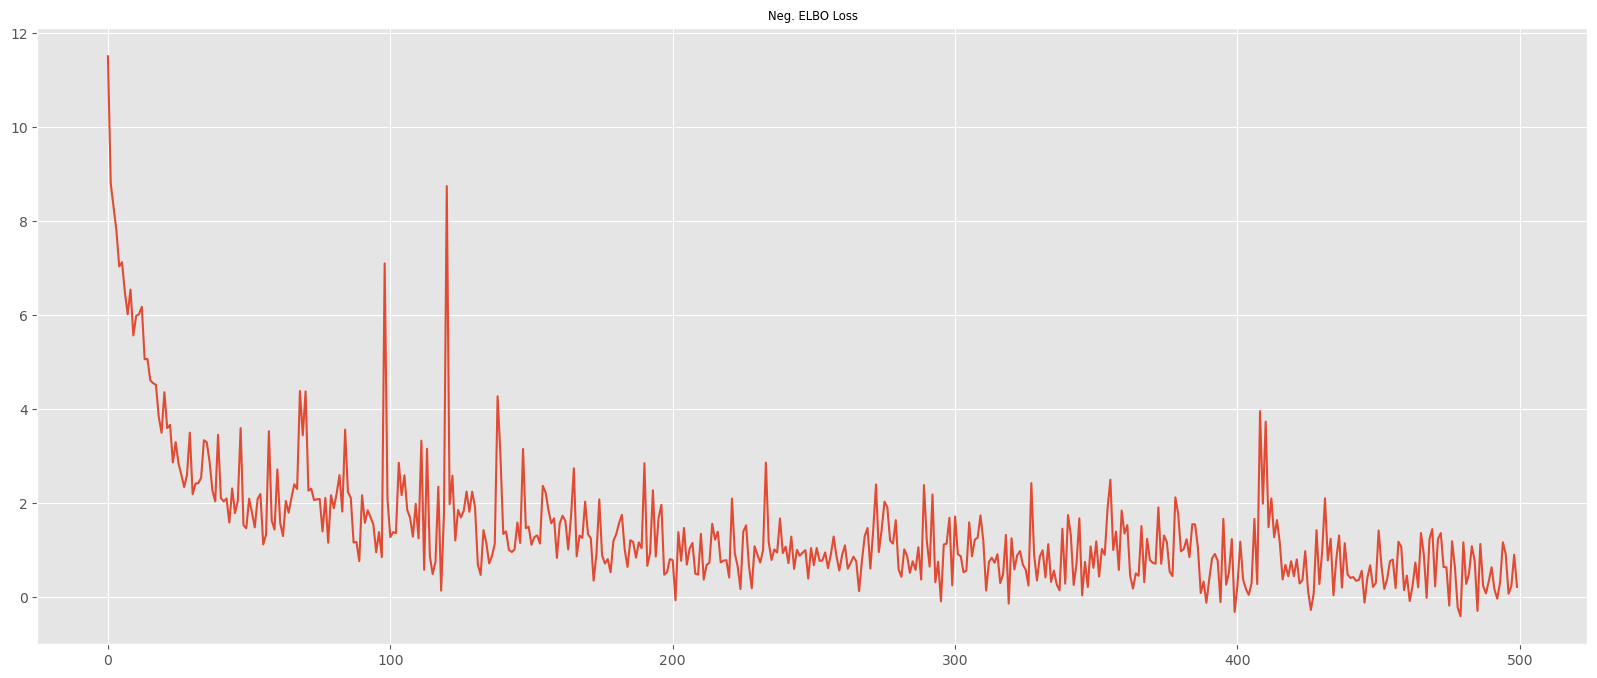

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(
    range(len(loss_list)),
    loss_list,
    label="batch_size=100",
)
plt.title("Neg. ELBO Loss", fontsize="small")
None